In [73]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [74]:
!pip install -qU "langchain[cohere]"


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
load_dotenv()

True

In [76]:
import getpass
import os

if not os.environ.get("COHERE_API_KEY"):
  os.environ["COHERE_API_KEY"] = getpass.getpass("Enter API key for Cohere: ")

from langchain.chat_models import init_chat_model

openai_model = init_chat_model("command-r-plus", model_provider="cohere")

In [77]:
openai_model.invoke("hi").content

'Hello! How can I help you today?'

In [78]:

def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [79]:
state={"num1":1, "num2":2}

In [80]:

add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [81]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [84]:
model_with_tool=openai_model.bind_tools([transfer_to_multiplication_expert])

In [85]:
ai_message=model_with_tool.invoke("hi how are you?")

In [86]:
ai_message.tool_calls

[]

In [87]:

ai_message=model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [88]:
ai_message

AIMessage(content='I will use the multiplication expert to calculate the answer to this query.', additional_kwargs={'id': 'ca0a9aa3-a6f8-468d-b585-a1c28ed42e8e', 'finish_reason': 'TOOL_CALL', 'tool_plan': 'I will use the multiplication expert to calculate the answer to this query.', 'tool_calls': [{'id': 'transfer_to_multiplication_expert_fv65aqxej02a', 'type': 'function', 'function': {'name': 'transfer_to_multiplication_expert', 'arguments': '{"expression":"(3 + 5) * 12"}'}}], 'token_count': {'input_tokens': 896.0, 'output_tokens': 69.0}}, response_metadata={'id': 'ca0a9aa3-a6f8-468d-b585-a1c28ed42e8e', 'finish_reason': 'TOOL_CALL', 'tool_plan': 'I will use the multiplication expert to calculate the answer to this query.', 'tool_calls': [{'id': 'transfer_to_multiplication_expert_fv65aqxej02a', 'type': 'function', 'function': {'name': 'transfer_to_multiplication_expert', 'arguments': '{"expression":"(3 + 5) * 12"}'}}], 'token_count': {'input_tokens': 896.0, 'output_tokens': 69.0}}, id=

In [89]:
ai_message.content

'I will use the multiplication expert to calculate the answer to this query.'

In [20]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {'expression': '(3 + 5) * 12'},
  'id': 'transfer_to_multiplication_expert_w2jaxnyg4508',
  'type': 'tool_call'}]

In [90]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [92]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [93]:
graph=StateGraph(MessagesState)

In [94]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)


In [95]:
graph.add_edge(START, "additional_expert")

In [96]:
app=graph.compile()

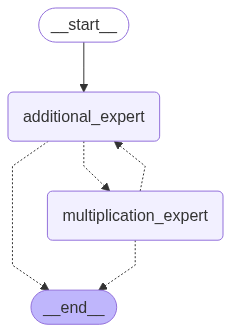

In [97]:
app=graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [98]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='ea221e24-9021-4d27-bc2b-91de2e036c37'),
  AIMessage(content='3 + 5 = 8', additional_kwargs={'id': '7773dd5c-5106-4370-a162-f7178ef45425', 'finish_reason': 'TOOL_CALL', 'tool_plan': '3 + 5 = 8', 'tool_calls': [{'id': 'transfer_to_multiplication_expert_avj7djm8gzkt', 'type': 'function', 'function': {'name': 'transfer_to_multiplication_expert', 'arguments': '{"question":"what is 8 * 12?"}'}}], 'token_count': {'input_tokens': 859.0, 'output_tokens': 62.0}}, response_metadata={'id': '7773dd5c-5106-4370-a162-f7178ef45425', 'finish_reason': 'TOOL_CALL', 'tool_plan': '3 + 5 = 8', 'tool_calls': [{'id': 'transfer_to_multiplication_expert_avj7djm8gzkt', 'type': 'function', 'function': {'name': 'transfer_to_multiplication_expert', 'arguments': '{"question":"what is 8 * 12?"}'}}], 'token_count': {'input_tokens': 859.0, 'output_tokens': 62.0}}, id='run--91387942-f822-4cc6-

In [100]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [101]:
from dotenv import load_dotenv

In [102]:
load_dotenv()

True

In [ ]:
TAVILY_API_KEY="TAVILY_API_KEY"
import os
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [104]:
tavaily_tool=TavilySearchResults()

In [ ]:
tavaily_tool.invoke("what is gnp?")

In [ ]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [111]:
code = """
x = 5
y = x * 2
print(y,end="")
"""

In [112]:
repl=PythonREPL()

In [113]:
repl.run(code)

'10'

In [114]:
members=["researcher","coder"]

In [115]:
options=members+["FINISH"]

In [118]:
options

['researcher', 'coder', 'FINISH']

In [119]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [132]:
from pydantic import BaseModel
from typing import Literal

class Router(BaseModel):
    next: Literal["researcher", "coder", "FINISH"]

In [120]:
class State(MessagesState):
    next:str

In [134]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [135]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [ ]:
# Instead of structured output, use a regular call and parse the response
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    # Add instructions to return JSON in the system prompt
    system_prompt_with_json = system_prompt + "\n\nRespond with a JSON object with a 'next' field containing either 'researcher', 'coder', or 'FINISH'."
    messages[0]["content"] = system_prompt_with_json
    
    response = openai_model.invoke(messages)
    
    # Parse the JSON response
    import json
    try:
        parsed = json.loads(response.content)
        goto = parsed["next"]
    except:
        # Fallback if JSON parsing fails
        goto = "researcher"  # or handle error appropriately
    
    print("below my goto**********************************")
    print(goto)
    
    if goto == "FINISH":
        goto = "__end__"  # Use "__end__" instead of END
        
    return Command(goto=goto, update={"next": goto})

In [136]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(openai_model, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [137]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(openai_model, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [138]:
graph=StateGraph(State)

In [139]:
graph.add_node("supervisor",supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)

graph.add_edge(START,"supervisor")
app=graph.compile()

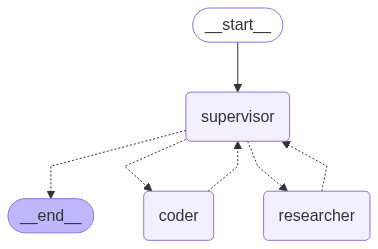

In [140]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")